In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metpy.calc as mpcalc
from metpy.units import units

#### Helper functions

In [26]:
# Water  movement from top --> bottom layer 
def Drainage(Wu, smcap):
    # D in the paper
    # Wu: water content of the upper layer
    # smcap: parameter
    if Wu > smcap:
        D = Wu - smcap
    else:
        D = 0
    # D is "drainage"
    return D

def Evaporation(PET, Wu, smcap):
    return PET * (Wu/smcap)

# def LenOfDay(lat=):
#     12+(12)/2 * sin[(2π/365)*(n-t) ] 
#     D=np.acos(np.tan(43.1)*np.tan(23.5))/7.5
              


def PET_Calc(L, T, etpar, pressure=850):
    # Potential evapotranspiration calculator
    # L: Length of day
    # rho_v_sat: staturated absolute humidity
    # etpar: parameter
    pressure_hpa = pressure * units("hPa")
    temperature_c = T * units("degC")
    
    sat_mix_rat = mpcalc.saturation_mixing_ratio(pressure_hpa, temperature_c)

    rho_v_sat = mpcalc.specific_humidity_from_mixing_ratio(sat_mix_rat)
    return etpar*L*rho_v_sat.m

# Snowmelt Functions 
def DDPar_Calc(T30, t_base, t_power):
    # T30: previous 30day mean temp
    # t_base: parameters
    # t_power: parameters
    
    k = 1.0 #mm/(d*C^2)
    if T30 > t_base:
        return (T30 - t_base)**t_power
    if T30 <= t_base:
        return t_base
    
def Ms(Td, Snow, tmelt, ddpar):
    # Td: temperature
    # Snow: amount in the bucket
    # ddpar: parameter (but not constant)
    # tmelt: parameter

    if Td > tmelt:
        melt = (Td-tmelt)*ddpar
        if melt > Snow: # check is there is enough snow to melt... 
            melt = Snow 
            return melt 
        else:
            return melt 
    else:
        return 0

#### Advance model forward one timestep

In [27]:
def one_time_forward(Pd, 
                     Td, 
                     T30,
                     Wu, 
                     Wb, 
                     Snow, 
                     L,
                     parameters):
    

    # Pd: Daily precipiation (mm/d)
    # Td: Daily temperature (T)
    # T30: Mean temperature from the previous 30 days
    # Wu: upper layer soil moisture (mm)
    # Wb: bottom layer soil moisture(mm)
    # Snow: Current snow bucket (mm)
    # L: length of day (hours)
    # parameters: instance of snow parameters class (see above)

    # Determine precipitation phase 
    # Add snow to snowpack if necessary 
    if Td >= parameters.t_snow:
        Pr = Pd
    else:
        Pr = 0                   # no rain

    # compute daily snow accumulation 
    Ps = Pd - Pr  # snow = total - rain 
    
    # Compute the snowmelt 
    # compute ddpar first 
    ddpar = DDPar_Calc(T30, parameters.t_base, parameters.t_power)
    Md = Ms(Td, Snow, parameters.t_melt, ddpar)

    # Compute the direct runoff (Qd)
    Qd = parameters.frtdir * (Pr + Md)

    # Compute the Soil Water input 
    Wi = (1-parameters.frtdir) * (Pr + Md) # Wi in paper
    
    # Compute drainage; 1st layer of soil --> 2nd layer of soil 
    D = Drainage(Wu, parameters.smcap)
    
    # Compute baseflow (bottom layer to runoff)
    Qb = Wb * parameters.frtgw
    
    # Compute PET
    # Firt compute saturation specific humidity 
    #rho_v_sat = .0001 # use mpcaclc to compute this 
    PET = PET_Calc(L, Td, parameters.etpar)
    print(PET)
    # Compute AET 
    E = PET*(Wu/parameters.smcap)
    
    # Compute change in the water balance of top layer
    dWudt = Wi - D - E
    
    # Compute change in water balance at bottom layer 
    dWbdt = D - Qb 
    
    # update values 
    # soil moisture
    Wb = Wb + dWbdt 
    Wu = Wu + dWudt 
    
    # snow
    Snow = Snow + Ps - Md # last snow, new snow, snow melt 
    
    # Compute discharge
    Q = Qb + Qd

    # now return things..
    return Snow, Wb, Wu, Qb, Qd, PET
    

#### Model Parameters 

In [28]:
# parameters 
class parms:
    frtdir = .3
    frtgw = .7 
    smcap = .80
    ddpar = 1. 
    etpar = .001
    tmelt = 1. 
    t_snow = 0.
    t_melt = 0.
    t_base = .5  # this for the ddpar calculation
    t_power = .5 # for ddpar calulation

parameters = parms()

#### synthetic forcings

In [29]:
# daily_temperature = 4*(np.sin(np.pi*(days/365)) - .5) + np.random.rand(ntimes) # also wrong/weird
# precip = np.random.rand(ntimes)*50 - 40 
# precip[np.where(precip <0)] = 0

# Time
# years = 10
# ntimes = 365*years
# days = np.linspace(1,ntimes,ntimes)

#### Initialize model buckets and Times

In [30]:
# Read observation stattes
database = "/Volumes/Transcend/EastRiverClimatePaper/Snotel/CO_snotel.db"
dbengine = "sqlite:///{}".format(database)

df = pd.read_sql_table('380', dbengine)
df = df.iloc[2200:2200+400]
df = df.reset_index()

times = df.Date
ntimes = len(times)
days = times.dt.dayofyear.values
DailyPrecip = df.IncPrecip.fillna(df.IncPrecip.mean()).values * 25.4 
DailyTemp = ((df.TavgF-32.0)*5/9)
DailyTemp = DailyTemp.fillna(DailyTemp.mean()).values


# # Forcings ... made up numbers
len_of_day_hr = 7*np.sin(np.pi*((days+8*30)/365))+7  # WRONG forumula. approx for beta test purposes

# Setup the Buckets 
Wb = np.zeros_like(days) + 100.0
Wu = np.zeros_like(days) + 100.0 
Snow = np.zeros_like(days)
Qb_array = np.zeros_like(days)
Qd_array = np.zeros_like(days)
PET = np.zeros_like(days)

In [31]:
# go 
for t in range(1,ntimes):
    L = len_of_day_hr[t]
    Pd = DailyPrecip[t]
    Td = DailyTemp[t]
    
    # get rid of nan values...
    if np.nan in [Pd, Td]:
        Q_array[t] = Q_array[t-1]
        Wb[t] = Wb[t-1]
        Wu[t] = Wu[t-1]
        Snow[t] = Snow[t-1]
        break 
        
    # compute T30; ignore temps from before the starting point...
    T30 = np.nanmean(DailyTemp[np.max([0, t-30]):t])
           
        
    Snow_t, Wb_t, Wu_t, Qb_t, Qd_t, PET_t = one_time_forward(Pd, Td, T30, Wu[t-1], Wb[t-1], Snow[t-1], L, parameters)
    Qb_array[t] = Qb_t
    Qd_array[t] = Qd_t
    Wb[t] = Wb_t
    Wu[t] = Wu_t
    Snow[t] = Snow_t
    PET[t] = PET_t

5.216612357763073e-07
5.959937916595698e-07
3.255833725915257e-07
2.602561724890679e-07
3.0430430956833434e-07
4.479714105672238e-07
3.609851122927398e-07
3.5650241808053047e-07
2.904299966271797e-07
2.2511666260755776e-07
1.6554550828676743e-07
1.5418753716878298e-07
1.3599498286485792e-07
1.301120224676484e-07
1.0652208762987585e-07
8.743120033767017e-08
7.375583070515016e-08
5.323232156867447e-08
4.1281474682769876e-08
2.7636412332216942e-08
1.3677693750937567e-08
5.923757315443114e-09
2.412192164942029e-09
2.469377860556612e-10
2.18072347942324e-10
2.132605295899904e-09
5.451606760431601e-09
6.385878274356186e-09
8.833640382136776e-09
1.2613776035649987e-08
2.2020684975926885e-08
3.6454154819657874e-08
5.3231063654821384e-08
6.936449508644315e-08
1.0018934529681374e-07
1.3052367243990226e-07
1.541875371687796e-07
2.0327711002538547e-07
2.344670695651375e-07
2.3695581568126467e-07
2.3708227749242578e-07
2.8972691713732217e-07
2.3113673327645784e-07
1.8921998327715274e-07
3.089596038

In [33]:
#plt.plot((Qb_array + Qd_array)) #[300:600])
#plt.plot(Snow)
PET

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

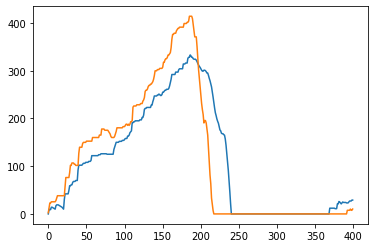

In [34]:
plt.plot(Snow)
plt.plot(df.SWE * 25.4)

In [35]:
PET = PET_Calc(L, Td, parameters.etpar)
PET

8.909502156314166e-08

In [17]:
Td

-2.2222222222222223